## **I - Math Assignment**



## **II - Coding Assignment**

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import torch 
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

### a - Read and preprocess the dataset using pandas

In [2]:
# 1. Load the dataset
df = pd.read_csv('bikeRidershipPredictionDataHour.csv')


# 2. Modify the categorial variables into dummy variables
categorical_vars = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
df = pd.get_dummies(df, columns=categorical_vars, drop_first=True)


# 3. Normalize continuous variables and the target using z-score
continuous_vars = ['temp', 'atemp', 'hum', 'windspeed', 'cnt']
means_std = {}

for col in continuous_vars:
    mean = df[col].mean()
    std = df[col].std()
    df[col] = (df[col] - mean) / std
    means_std[col] = (mean, std)


# 4. Exclude the useless features in your training and modeling
df.drop(['instant', 'dteday', 'casual', 'registered'], axis=1, inplace=True)


# 5. Separate the training and validation data (last 21 days for validation)
validation_set_size = 21 * 24 # 21 days * 24 hours
train_df = df[:-validation_set_size]
val_df = df[-validation_set_size:]


# 6. Preparing features and targets
X_train = train_df.drop('cnt', axis=1).values.astype(np.float32)
y_train = train_df['cnt'].values.astype(np.float32)

X_val = val_df.drop('cnt', axis=1).values.astype(np.float32)
y_val = val_df['cnt'].values.astype(np.float32)

### b - Develop a neural network in PyTorch to model and predit 'cnt'

In [3]:
# 1. Create PyTorch Dataset and DataLoader
# Custom Dataset definition:
class BikeDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create PyTorch Dataset
train_dataset = BikeDataset(X_train, y_train)
val_dataset = BikeDataset(X_val, y_val)

# Create DataLoader
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [4]:
# 2. Building the Neural Network Model 
class FlexibleBikeNet(nn.Module):
    def __init__(self, input_dim, hidden_layers_sizes=[64, 32]):
        super(FlexibleBikeNet, self).__init__()
        layers = []
        prev_size = input_dim
        # Create hidden layers dynamically
        for layer_size in hidden_layers_sizes:
            layers.append(nn.Linear(prev_size, layer_size))
            layers.append(nn.ReLU())
            prev_size = layer_size
        layers.append(nn.Linear(prev_size, 1))  # Output layer
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [5]:
# 4. Training the Model
# Experiment with Different Structures & Optimizers 
experiment_configs = [
    {'layers': [64], 'optimizer': optim.Adam, 'lr': 0.001, 'epochs': 50},
    {'layers': [128, 64], 'optimizer': optim.Adam, 'lr': 0.0005, 'epochs': 70},
    {'layers': [128, 64, 32], 'optimizer': optim.Adam, 'lr': 0.0005, 'epochs': 70},
    {'layers': [256, 128, 64], 'optimizer': optim.SGD, 'lr': 0.01, 'epochs': 100},
]

results_summary = []
best_model, best_r2 = None, -np.inf

for idx, config in enumerate(experiment_configs, 1):
    print(f"\nExperiment {idx}/{len(experiment_configs)} - config: {config}")

    model = FlexibleBikeNet(X_train.shape[1], config['layers'])
    criterion = nn.MSELoss()
    optimizer = config['optimizer'](model.parameters(), lr=config['lr'])

    for epoch in range(config['epochs']):
        model.train()
        epoch_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * X_batch.size(0)
        epoch_loss /= len(train_loader.dataset)

        # Optional: Print every 10 epochs
        if (epoch+1) % 10 == 0:
            print(f"Epoch {epoch+1}/{config['epochs']} - Loss: {epoch_loss:.4f}")

    # Evaluate on validation set
    model.eval()
    with torch.no_grad():
        val_preds = model(torch.tensor(X_val, dtype=torch.float32)).numpy().flatten()
        val_mse = mean_squared_error(y_val, val_preds)
        val_r2 = r2_score(y_val, val_preds)

    print(f"Validation R2: {val_r2:.4f}, Validation MSE: {val_mse:.4f}")

    results_summary.append({
        'config': config,
        'val_r2': val_r2,
        'val_mse': val_mse
    })

    # Track best model
    if val_r2 > best_r2:
        best_r2 = val_r2
        best_model = model


Experiment 1/4 - config: {'layers': [64], 'optimizer': <class 'torch.optim.adam.Adam'>, 'lr': 0.001, 'epochs': 50}
Epoch 10/50 - Loss: 0.0537
Epoch 20/50 - Loss: 0.0447
Epoch 30/50 - Loss: 0.0411
Epoch 40/50 - Loss: 0.0397
Epoch 50/50 - Loss: 0.0385
Validation R2: 0.7878, Validation MSE: 0.1406

Experiment 2/4 - config: {'layers': [128, 64], 'optimizer': <class 'torch.optim.adam.Adam'>, 'lr': 0.0005, 'epochs': 70}
Epoch 10/70 - Loss: 0.0442
Epoch 20/70 - Loss: 0.0358
Epoch 30/70 - Loss: 0.0305
Epoch 40/70 - Loss: 0.0281
Epoch 50/70 - Loss: 0.0253
Epoch 60/70 - Loss: 0.0237
Epoch 70/70 - Loss: 0.0220
Validation R2: 0.8690, Validation MSE: 0.0868

Experiment 3/4 - config: {'layers': [128, 64, 32], 'optimizer': <class 'torch.optim.adam.Adam'>, 'lr': 0.0005, 'epochs': 70}
Epoch 10/70 - Loss: 0.0437
Epoch 20/70 - Loss: 0.0348
Epoch 30/70 - Loss: 0.0290
Epoch 40/70 - Loss: 0.0256
Epoch 50/70 - Loss: 0.0236
Epoch 60/70 - Loss: 0.0203
Epoch 70/70 - Loss: 0.0188
Validation R2: 0.8060, Validati

In [6]:
# 5. Evaluate validation results using R-square and MSE
print("\n=== Experiment Summary ===")
for idx, res in enumerate(results_summary, 1):
    print(f"\nExperiment {idx}:")
    print(f"Configuration: {res['config']}")
    print(f"Validation R-square: {res['val_r2']:.4f}")
    print(f"Validation MSE: {res['val_mse']:.4f}")


=== Experiment Summary ===

Experiment 1:
Configuration: {'layers': [64], 'optimizer': <class 'torch.optim.adam.Adam'>, 'lr': 0.001, 'epochs': 50}
Validation R-square: 0.7878
Validation MSE: 0.1406

Experiment 2:
Configuration: {'layers': [128, 64], 'optimizer': <class 'torch.optim.adam.Adam'>, 'lr': 0.0005, 'epochs': 70}
Validation R-square: 0.8690
Validation MSE: 0.0868

Experiment 3:
Configuration: {'layers': [128, 64, 32], 'optimizer': <class 'torch.optim.adam.Adam'>, 'lr': 0.0005, 'epochs': 70}
Validation R-square: 0.8060
Validation MSE: 0.1286

Experiment 4:
Configuration: {'layers': [256, 128, 64], 'optimizer': <class 'torch.optim.sgd.SGD'>, 'lr': 0.01, 'epochs': 100}
Validation R-square: 0.8124
Validation MSE: 0.1243


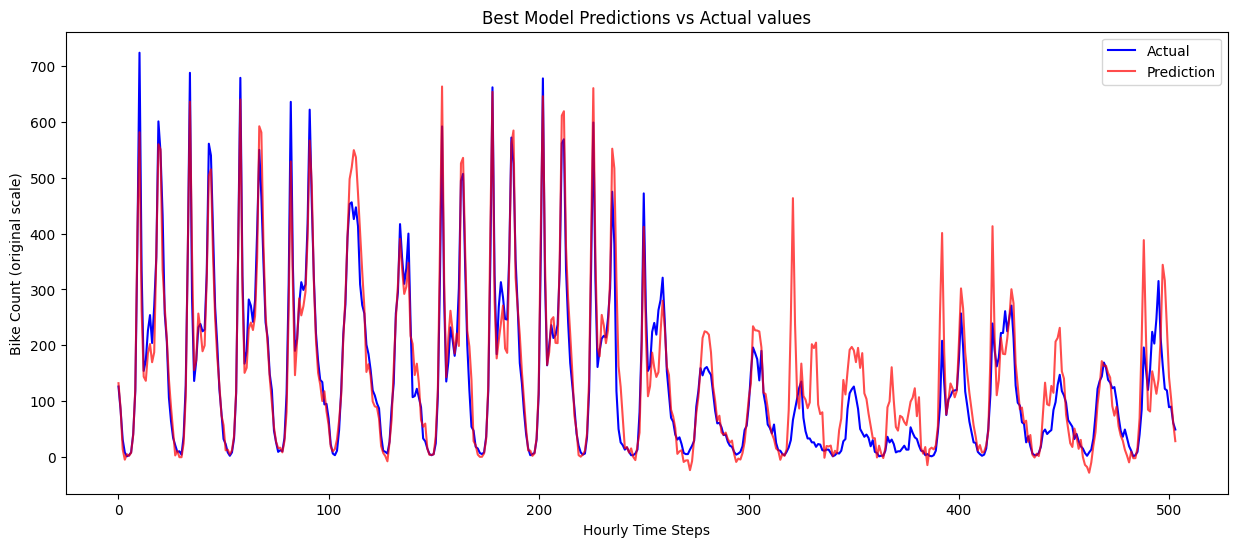

In [7]:
# 6. Visualize the Best Model's Predictions
best_model.eval()
with torch.no_grad():
    best_preds = best_model(torch.tensor(X_val, dtype=torch.float32)).numpy().flatten()

# Restore original scale for visualization
cnt_mean, cnt_std = means_std['cnt']
true_vals_original = y_val * cnt_std + cnt_mean
pred_vals_original = best_preds * cnt_std + cnt_mean

plt.figure(figsize=(15,6))
plt.plot(true_vals_original, label='Actual', color='blue')
plt.plot(pred_vals_original, label='Prediction', color='red', alpha=0.7)
plt.xlabel("Hourly Time Steps")
plt.ylabel("Bike Count (original scale)")
plt.title("Best Model Predictions vs Actual values")
plt.legend()
plt.show()